In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v6 import Autoencoder
from tools.GRU_SingleStep_v11 import RNN_GRU
# from tools.LSTM_SingleStep_v2 import RNN_GRU
# from tools.SimpleRNN_SingleStep_v2 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-01-22 13:59:09.529610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 13:59:09.529905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 13:59:09.565362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 13:59:09.565625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 13:59:09.565908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-22 13:59:09.567479: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 13:59:09.568021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 13:59:09.568392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 13:59:09.568699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_015'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    try:
        use_ae_data = params_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in sim_data_AE_params, set to True.")
        normalize_dataset = True
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

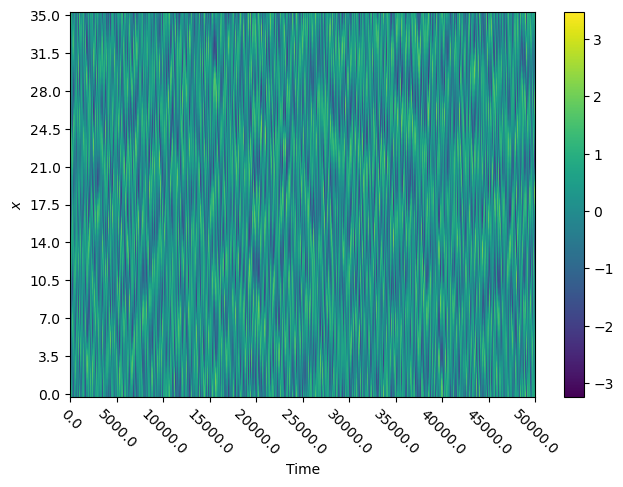

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

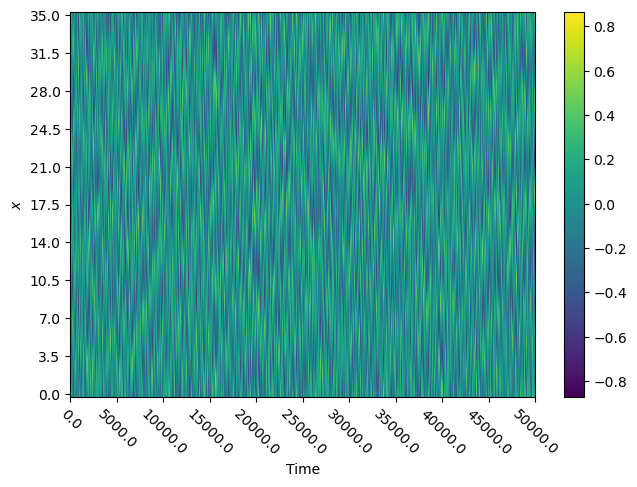

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

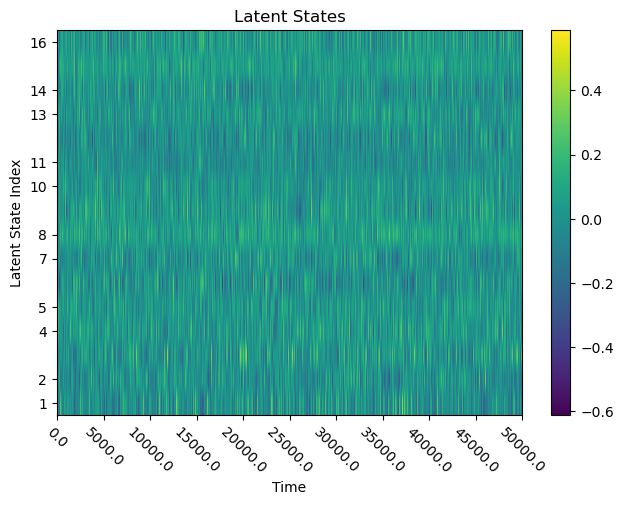

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5 # int(5000/np.mean(lyapunov_time_arr))#
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'

    # can be 'minmax', 'minmax2', 'stddev', or a list with
    # sequential order of any of these; if it is 'minmax'
    # then stddev_multiplier has no effect
    normalization_type = 'stddev'
    stddev_multiplier = 3

    dense_layer_act_func = ['tanh']
    use_weights_post_dense = True
    stateful = True
    use_learnable_state = False
    use_trainable_weights_with_reslayers = False
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
        'stateful':stateful,
        'use_learnable_state':use_learnable_state,
        'use_weights_post_dense':use_weights_post_dense,
        'use_trainable_weights_with_reslayers':use_trainable_weights_with_reslayers,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 10 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 2/100
    zoneout_rate = 0.0
    rnncell_dropout_rate = 0.0
    denselayer_dropout_rate = 0.0
    

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'zoneout_rate':zoneout_rate,
        'rnncell_dropout_rate':rnncell_dropout_rate,
        'denselayer_dropout_rate':denselayer_dropout_rate,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (512, 387, 16)
 testing_data_rnn_input.shape :  (64, 387, 16)
     val_data_rnn_input.shape :  (64, 387, 16)


In [30]:
# print(rnn_data_boundary_idx_arr)

In [31]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
#     rnn_layers_units = [500]*3
#     scalar_weights = None
    # scalar_weights = [
    #     0.5, 
    #     0.0, 0.5,
    #     0.0, 0.0, 1.0,
    #     1/6, 1/3, 1/3, 1/6
    # ] # RK4
    # scalar_weights = [
    #     1.0,
    #     0.25, 0.25,
    #     1/6, 1/6, 2/3
    # ] # TVD RK3
    scalar_weights = [
        1.0,
        0.5, 0.5
    ] # TVD RK2
    rnn_layers_units = [200]*int(1 + ((8*len(scalar_weights)+1)**0.5 - 1)/2)
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim,
                use_learnable_state=use_learnable_state,
                stateful=stateful,
                zoneout_rate=zoneout_rate,
                batch_size=batch_size,
                use_weights_post_dense=use_weights_post_dense,
                rnncell_dropout_rate=rnncell_dropout_rate,
                denselayer_dropout_rate=denselayer_dropout_rate,
                scalar_weights=scalar_weights, # corresponding to RK4
                use_trainable_weights_with_reslayers=use_trainable_weights_with_reslayers,
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim,
            use_learnable_state=use_learnable_state,
            stateful=stateful,
            zoneout_rate=zoneout_rate,
            batch_size=batch_size,
            use_weights_post_dense=use_weights_post_dense,
            rnncell_dropout_rate=rnncell_dropout_rate,
            denselayer_dropout_rate=denselayer_dropout_rate,
            scalar_weights=scalar_weights, # corresponding to RK4
            use_trainable_weights_with_reslayers=use_trainable_weights_with_reslayers,
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                batch_size=batch_size,
                
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            batch_size=batch_size
        )

    rnn_net.build(input_shape=(batch_size, None, num_latent_states))
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.006613247394561768


In [32]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [33]:
train_NMSE_hist = []
val_NMSE_hist = []

train_MSE_hist = []
val_MSE_hist = []

In [34]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [35]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])

        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 0.0591 - mse: 0.0587 - NMSE: 0.5285 - tot_time: 0h 0m 9.8s

Epoch 1: val_NMSE improved from inf to 0.17808, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 10s 926ms/step - loss: 0.0591 - mse: 0.0587 - NMSE: 0.5285 - val_loss: 0.0202 - val_mse: 0.0198 - val_NMSE: 0.1781
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 0.0142 - mse: 0.0138 - NMSE: 0.1243 - tot_time: 0h 0m 16.2s

Epoch 2: val_NMSE improved from 0.17808 to 0.08741, saving model to /ho

8/8 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0015 - NMSE: 0.0137 - tot_time: 0h 1m 42.3s

Epoch 15: val_NMSE improved from 0.01710 to 0.01605, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 806ms/step - loss: 0.0019 - mse: 0.0015 - NMSE: 0.0137 - val_loss: 0.0021 - val_mse: 0.0018 - val_NMSE: 0.0160
Epoch 16/1000
8/8 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 1m 48.5s

Epoch 16: val_NMSE improved from 0.01605 to 0.01510, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 779ms/step 

Epoch 30/1000
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 7.2307e-04 - NMSE: 0.0065 - tot_time: 0h 3m 22.3s

Epoch 30: val_NMSE improved from 0.00887 to 0.00865, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 851ms/step - loss: 0.0010 - mse: 7.2307e-04 - NMSE: 0.0065 - val_loss: 0.0013 - val_mse: 9.6114e-04 - val_NMSE: 0.0087
Epoch 31/1000
8/8 [==============================] - ETA: 0s - loss: 0.0010 - mse: 7.0213e-04 - NMSE: 0.0063 - tot_time: 0h 3m 29.2s

Epoch 31: val_NMSE improved from 0.00865 to 0.00846, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 857ms/step - loss: 8.0188e-04 - mse: 5.4103e-04 - NMSE: 0.0049 - val_loss: 0.0010 - val_mse: 7.6215e-04 - val_NMSE: 0.0069
Epoch 45/1000
8/8 [==============================] - ETA: 0s - loss: 7.9121e-04 - mse: 5.3303e-04 - NMSE: 0.0048 - tot_time: 0h 5m 4.0s

Epoch 45: val_NMSE improved from 0.00686 to 0.00678, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 830ms/step - loss: 7.9121e-04 - mse: 5.3303e-04 - NMSE: 0.0048 - val_loss: 0.0010 - val_mse: 7.5367e-04 - val_NMSE: 0.0068
Epoch 46/1000
8/8 [==============================] - ETA: 0s - loss: 7.8100e-04 - mse: 5.2542e-04 - NMSE: 0.0047 - tot_time: 0h 5m 10.7s

Epoch 59/1000
8/8 [==============================] - ETA: 0s - loss: 6.7658e-04 - mse: 4.4747e-04 - NMSE: 0.0040 - tot_time: 0h 6m 38.0s

Epoch 59: val_NMSE improved from 0.00596 to 0.00590, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 869ms/step - loss: 6.7658e-04 - mse: 4.4747e-04 - NMSE: 0.0040 - val_loss: 8.8404e-04 - val_mse: 6.5582e-04 - val_NMSE: 0.0059
Epoch 60/1000
8/8 [==============================] - ETA: 0s - loss: 6.7039e-04 - mse: 4.4283e-04 - NMSE: 0.0040 - tot_time: 0h 6m 44.7s

Epoch 60: val_NMSE improved from 0.00590 to 0.00585, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==

8/8 [==============================] - ETA: 0s - loss: 6.0357e-04 - mse: 3.9146e-04 - NMSE: 0.0035 - tot_time: 0h 8m 11.2s

Epoch 73: val_NMSE improved from 0.00530 to 0.00526, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 826ms/step - loss: 6.0357e-04 - mse: 3.9146e-04 - NMSE: 0.0035 - val_loss: 7.9577e-04 - val_mse: 5.8417e-04 - val_NMSE: 0.0053
Epoch 74/1000
8/8 [==============================] - ETA: 0s - loss: 5.9943e-04 - mse: 3.8821e-04 - NMSE: 0.0035 - tot_time: 0h 8m 17.5s

Epoch 74: val_NMSE improved from 0.00526 to 0.00522, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [================

8/8 [==============================] - ETA: 0s - loss: 5.5279e-04 - mse: 3.5064e-04 - NMSE: 0.0032 - tot_time: 0h 9m 44.8s

Epoch 87: val_NMSE improved from 0.00479 to 0.00476, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 797ms/step - loss: 5.5279e-04 - mse: 3.5064e-04 - NMSE: 0.0032 - val_loss: 7.3040e-04 - val_mse: 5.2856e-04 - val_NMSE: 0.0048
Epoch 88/1000
8/8 [==============================] - ETA: 0s - loss: 5.4965e-04 - mse: 3.4804e-04 - NMSE: 0.0031 - tot_time: 0h 9m 51.4s

Epoch 88: val_NMSE improved from 0.00476 to 0.00472, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [================

8/8 [==============================] - ETA: 0s - loss: 5.1448e-04 - mse: 3.1863e-04 - NMSE: 0.0029 - tot_time: 0h 11m 17.9s

Epoch 101: val_NMSE improved from 0.00440 to 0.00438, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 826ms/step - loss: 5.1448e-04 - mse: 3.1863e-04 - NMSE: 0.0029 - val_loss: 6.8226e-04 - val_mse: 4.8663e-04 - val_NMSE: 0.0044
Epoch 102/1000
8/8 [==============================] - ETA: 0s - loss: 5.1200e-04 - mse: 3.1653e-04 - NMSE: 0.0028 - tot_time: 0h 11m 24.2s

Epoch 102: val_NMSE improved from 0.00438 to 0.00435, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [===========

8/8 [==============================] - ETA: 0s - loss: 4.8282e-04 - mse: 2.9148e-04 - NMSE: 0.0026 - tot_time: 0h 12m 51.8s

Epoch 115: val_NMSE improved from 0.00407 to 0.00405, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 871ms/step - loss: 4.8282e-04 - mse: 2.9148e-04 - NMSE: 0.0026 - val_loss: 6.4100e-04 - val_mse: 4.4982e-04 - val_NMSE: 0.0040
Epoch 116/1000
8/8 [==============================] - ETA: 0s - loss: 4.8088e-04 - mse: 2.8982e-04 - NMSE: 0.0026 - tot_time: 0h 12m 58.4s

Epoch 116: val_NMSE improved from 0.00405 to 0.00403, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [===========

8/8 [==============================] - ETA: 0s - loss: 4.5377e-04 - mse: 2.6589e-04 - NMSE: 0.0024 - tot_time: 0h 14m 24.6s

Epoch 129: val_NMSE improved from 0.00377 to 0.00375, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 856ms/step - loss: 4.5377e-04 - mse: 2.6589e-04 - NMSE: 0.0024 - val_loss: 6.0405e-04 - val_mse: 4.1630e-04 - val_NMSE: 0.0037
Epoch 130/1000
8/8 [==============================] - ETA: 0s - loss: 4.5143e-04 - mse: 2.6377e-04 - NMSE: 0.0024 - tot_time: 0h 14m 31.0s

Epoch 130: val_NMSE improved from 0.00375 to 0.00373, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [===========

8/8 [==============================] - ETA: 0s - loss: 4.2489e-04 - mse: 2.3978e-04 - NMSE: 0.0022 - tot_time: 0h 15m 58.1s

Epoch 143: val_NMSE improved from 0.00347 to 0.00344, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 847ms/step - loss: 4.2489e-04 - mse: 2.3978e-04 - NMSE: 0.0022 - val_loss: 5.6741e-04 - val_mse: 3.8241e-04 - val_NMSE: 0.0034
Epoch 144/1000
8/8 [==============================] - ETA: 0s - loss: 4.2337e-04 - mse: 2.3845e-04 - NMSE: 0.0021 - tot_time: 0h 16m 4.8s

Epoch 144: val_NMSE did not improve from 0.00344
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 859ms/step - loss: 4.2337e-04 - mse: 2.3845e-04 - NMSE: 0.0021 - val_loss: 5.7

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 826ms/step - loss: 3.9779e-04 - mse: 2.1547e-04 - NMSE: 0.0019 - val_loss: 5.3268e-04 - val_mse: 3.5049e-04 - val_NMSE: 0.0032
Epoch 158/1000
8/8 [==============================] - ETA: 0s - loss: 3.9717e-04 - mse: 2.1508e-04 - NMSE: 0.0019 - tot_time: 0h 17m 37.7s

Epoch 158: val_NMSE did not improve from 0.00315
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 862ms/step - loss: 3.9717e-04 - mse: 2.1508e-04 - NMSE: 0.0019 - val_loss: 5.3335e-04 - val_mse: 3.5139e-04 - val_NMSE: 0.0032
Epoch 159/1000
8/8 [==============================] - ETA: 0s - loss: 3.9650e-04 - mse: 2.1464e-04 - NMSE: 0.0019 - tot_time: 0h 17m 44.4s

Epoch 159: val_NMSE improved from 0.00315 to 0.00315, saving model to /home/rkaushik/Do

Epoch 172/1000
8/8 [==============================] - ETA: 0s - loss: 3.7484e-04 - mse: 1.9610e-04 - NMSE: 0.0018 - tot_time: 0h 19m 12.5s

Epoch 172: val_NMSE improved from 0.00293 to 0.00291, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 813ms/step - loss: 3.7484e-04 - mse: 1.9610e-04 - NMSE: 0.0018 - val_loss: 5.0236e-04 - val_mse: 3.2376e-04 - val_NMSE: 0.0029
Epoch 173/1000
8/8 [==============================] - ETA: 0s - loss: 3.7399e-04 - mse: 1.9549e-04 - NMSE: 0.0018 - tot_time: 0h 19m 19.0s

Epoch 173: val_NMSE improved from 0.00291 to 0.00290, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8

Epoch 187/1000
8/8 [==============================] - ETA: 0s - loss: 3.6318e-04 - mse: 1.8800e-04 - NMSE: 0.0017 - tot_time: 0h 20m 51.2s

Epoch 187: val_NMSE improved from 0.00278 to 0.00274, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 832ms/step - loss: 3.6318e-04 - mse: 1.8800e-04 - NMSE: 0.0017 - val_loss: 4.7997e-04 - val_mse: 3.0491e-04 - val_NMSE: 0.0027
Epoch 188/1000
8/8 [==============================] - ETA: 0s - loss: 3.6279e-04 - mse: 1.8782e-04 - NMSE: 0.0017 - tot_time: 0h 20m 57.9s

Epoch 188: val_NMSE improved from 0.00274 to 0.00274, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8

Epoch 202/1000
8/8 [==============================] - ETA: 0s - loss: 3.4673e-04 - mse: 1.7492e-04 - NMSE: 0.0016 - tot_time: 0h 22m 30.6s

Epoch 202: val_NMSE improved from 0.00263 to 0.00261, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 853ms/step - loss: 3.4673e-04 - mse: 1.7492e-04 - NMSE: 0.0016 - val_loss: 4.6183e-04 - val_mse: 2.9015e-04 - val_NMSE: 0.0026
Epoch 203/1000
8/8 [==============================] - ETA: 0s - loss: 3.4620e-04 - mse: 1.7461e-04 - NMSE: 0.0016 - tot_time: 0h 22m 37.1s

Epoch 203: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 833ms/step - loss: 3.4620e-04 - mse: 1.7461e-04 - NMSE: 0.0016

Epoch 217/1000
8/8 [==============================] - ETA: 0s - loss: 3.3414e-04 - mse: 1.6565e-04 - NMSE: 0.0015 - tot_time: 0h 24m 8.8s

Epoch 217: val_NMSE improved from 0.00248 to 0.00248, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 835ms/step - loss: 3.3414e-04 - mse: 1.6565e-04 - NMSE: 0.0015 - val_loss: 4.4368e-04 - val_mse: 2.7530e-04 - val_NMSE: 0.0025
Epoch 218/1000
8/8 [==============================] - ETA: 0s - loss: 3.3328e-04 - mse: 1.6500e-04 - NMSE: 0.0015 - tot_time: 0h 24m 15.3s

Epoch 218: val_NMSE improved from 0.00248 to 0.00247, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 834ms/step - loss: 3.2411e-04 - mse: 1.5860e-04 - NMSE: 0.0014 - val_loss: 4.2875e-04 - val_mse: 2.6336e-04 - val_NMSE: 0.0024
Epoch 232/1000
8/8 [==============================] - ETA: 0s - loss: 3.2243e-04 - mse: 1.5712e-04 - NMSE: 0.0014 - tot_time: 0h 25m 45.4s

Epoch 232: val_NMSE improved from 0.00237 to 0.00235, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 849ms/step - loss: 3.2243e-04 - mse: 1.5712e-04 - NMSE: 0.0014 - val_loss: 4.2587e-04 - val_mse: 2.6069e-04 - val_NMSE: 0.0023
Epoch 233/1000
8/8 [==============================] - ETA: 0s - loss: 3.2114e-04 - mse: 1.5605e-04 - NMSE: 0.0014 - tot_time

Epoch 247/1000
8/8 [==============================] - ETA: 0s - loss: 3.1285e-04 - mse: 1.5065e-04 - NMSE: 0.0014 - tot_time: 0h 27m 23.2s

Epoch 247: val_NMSE improved from 0.00227 to 0.00225, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 810ms/step - loss: 3.1285e-04 - mse: 1.5065e-04 - NMSE: 0.0014 - val_loss: 4.1259e-04 - val_mse: 2.5051e-04 - val_NMSE: 0.0023
Epoch 248/1000
8/8 [==============================] - ETA: 0s - loss: 3.1220e-04 - mse: 1.5020e-04 - NMSE: 0.0014 - tot_time: 0h 27m 29.5s

Epoch 248: val_NMSE improved from 0.00225 to 0.00224, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 795ms/step - loss: 3.0251e-04 - mse: 1.4332e-04 - NMSE: 0.0013 - val_loss: 3.9972e-04 - val_mse: 2.4065e-04 - val_NMSE: 0.0022
Epoch 263/1000
8/8 [==============================] - ETA: 0s - loss: 3.0139e-04 - mse: 1.4241e-04 - NMSE: 0.0013 - tot_time: 0h 29m 7.2s

Epoch 263: val_NMSE improved from 0.00217 to 0.00216, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 944ms/step - loss: 3.0139e-04 - mse: 1.4241e-04 - NMSE: 0.0013 - val_loss: 3.9838e-04 - val_mse: 2.3951e-04 - val_NMSE: 0.0022
Epoch 264/1000
8/8 [==============================] - ETA: 0s - loss: 2.9998e-04 - mse: 1.4119e-04 - NMSE: 0.0013 - tot_time:

Epoch 278/1000
8/8 [==============================] - ETA: 0s - loss: 2.9432e-04 - mse: 1.3829e-04 - NMSE: 0.0012 - tot_time: 0h 30m 46.4s

Epoch 278: val_NMSE improved from 0.00209 to 0.00207, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 808ms/step - loss: 2.9432e-04 - mse: 1.3829e-04 - NMSE: 0.0012 - val_loss: 3.8631e-04 - val_mse: 2.3039e-04 - val_NMSE: 0.0021
Epoch 279/1000
8/8 [==============================] - ETA: 0s - loss: 2.9482e-04 - mse: 1.3898e-04 - NMSE: 0.0013 - tot_time: 0h 30m 52.9s

Epoch 279: val_NMSE did not improve from 0.00207
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 811ms/step - loss: 2.9482e-04 - mse: 1.3898e-04 - NMSE: 0.0013

Epoch 293/1000
8/8 [==============================] - ETA: 0s - loss: 2.8361e-04 - mse: 1.3042e-04 - NMSE: 0.0012 - tot_time: 0h 32m 24.3s

Epoch 293: val_NMSE did not improve from 0.00198
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 783ms/step - loss: 2.8361e-04 - mse: 1.3042e-04 - NMSE: 0.0012 - val_loss: 3.7624e-04 - val_mse: 2.2316e-04 - val_NMSE: 0.0020
Epoch 294/1000
8/8 [==============================] - ETA: 0s - loss: 2.8305e-04 - mse: 1.3005e-04 - NMSE: 0.0012 - tot_time: 0h 32m 30.6s

Epoch 294: val_NMSE did not improve from 0.00198
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 792ms/step - loss: 2.8305e-04 - mse: 1.3005e-04 - NMSE: 0.0012 - val_loss: 3.7512e-04 - val_mse: 2.2223e-04 - val_NMSE: 0.0020
Epoch 295/1000
8/8 [==================

Epoch 309/1000
8/8 [==============================] - ETA: 0s - loss: 2.7811e-04 - mse: 1.2787e-04 - NMSE: 0.0012 - tot_time: 0h 34m 9.2s

Epoch 309: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 775ms/step - loss: 2.7811e-04 - mse: 1.2787e-04 - NMSE: 0.0012 - val_loss: 3.6627e-04 - val_mse: 2.1613e-04 - val_NMSE: 0.0019
Epoch 310/1000
8/8 [==============================] - ETA: 0s - loss: 2.7776e-04 - mse: 1.2770e-04 - NMSE: 0.0011 - tot_time: 0h 34m 15.5s

Epoch 310: val_NMSE did not improve from 0.00191
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 795ms/step - loss: 2.7776e-04 - mse: 1.2770e-04 - NMSE: 0.0011 - val_loss: 3.6352e-04 - val_mse: 2.1356e-04 - val_NMSE: 0.0019
Epoch 311/1000
8/8 [===================

Epoch 325/1000
8/8 [==============================] - ETA: 0s - loss: 2.6718e-04 - mse: 1.1977e-04 - NMSE: 0.0011 - tot_time: 0h 35m 54.6s

Epoch 325: val_NMSE did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 839ms/step - loss: 2.6718e-04 - mse: 1.1977e-04 - NMSE: 0.0011 - val_loss: 3.5310e-04 - val_mse: 2.0578e-04 - val_NMSE: 0.0019
Epoch 326/1000
8/8 [==============================] - ETA: 0s - loss: 2.6861e-04 - mse: 1.2138e-04 - NMSE: 0.0011 - tot_time: 0h 36m 0.9s

Epoch 326: val_NMSE did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 794ms/step - loss: 2.6861e-04 - mse: 1.2138e-04 - NMSE: 0.0011 - val_loss: 3.5071e-04 - val_mse: 2.0358e-04 - val_NMSE: 0.0018
Epoch 327/1000
8/8 [===================

8/8 [==============================] - ETA: 0s - loss: 2.6127e-04 - mse: 1.1661e-04 - NMSE: 0.0010 - tot_time: 0h 37m 40.0s

Epoch 341: val_NMSE improved from 0.00178 to 0.00176, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 842ms/step - loss: 2.6127e-04 - mse: 1.1661e-04 - NMSE: 0.0010 - val_loss: 3.4059e-04 - val_mse: 1.9602e-04 - val_NMSE: 0.0018
Epoch 342/1000
8/8 [==============================] - ETA: 0s - loss: 2.5987e-04 - mse: 1.1537e-04 - NMSE: 0.0010 - tot_time: 0h 37m 46.7s

Epoch 342: val_NMSE did not improve from 0.00176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 831ms/step - loss: 2.5987e-04 - mse: 1.1537e-04 - NMSE: 0.0010 - val_loss: 3.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 838ms/step - loss: 2.4955e-04 - mse: 1.0739e-04 - NMSE: 9.6667e-04 - val_loss: 3.2724e-04 - val_mse: 1.8517e-04 - val_NMSE: 0.0017
Epoch 357/1000
8/8 [==============================] - ETA: 0s - loss: 2.5044e-04 - mse: 1.0844e-04 - NMSE: 9.7614e-04 - tot_time: 0h 39m 25.5s

Epoch 357: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 820ms/step - loss: 2.5044e-04 - mse: 1.0844e-04 - NMSE: 9.7614e-04 - val_loss: 3.3034e-04 - val_mse: 1.8844e-04 - val_NMSE: 0.0017
Epoch 358/1000
8/8 [==============================] - ETA: 0s - loss: 2.5097e-04 - mse: 1.0914e-04 - NMSE: 9.8241e-04 - tot_time: 0h 39m 32.0s

Epoch 358: val_NMSE did not improve from 0.00167
 - saving loss histori

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 800ms/step - loss: 2.4430e-04 - mse: 1.0475e-04 - NMSE: 9.4291e-04 - val_loss: 3.1857e-04 - val_mse: 1.7911e-04 - val_NMSE: 0.0016
Epoch 373/1000
8/8 [==============================] - ETA: 0s - loss: 2.4322e-04 - mse: 1.0383e-04 - NMSE: 9.3460e-04 - tot_time: 0h 41m 10.3s

Epoch 373: val_NMSE did not improve from 0.00161
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 876ms/step - loss: 2.4322e-04 - mse: 1.0383e-04 - NMSE: 9.3460e-04 - val_loss: 3.1894e-04 - val_mse: 1.7964e-04 - val_NMSE: 0.0016
Epoch 374/1000
8/8 [==============================] - ETA: 0s - loss: 2.4170e-04 - mse: 1.0246e-04 - NMSE: 9.2228e-04 - tot_time: 0h 41m 17.0s

Epoch 374: val_NMSE improved from 0.00161 to 0.00158, saving model to /

Epoch 388/1000
8/8 [==============================] - ETA: 0s - loss: 2.3619e-04 - mse: 9.9215e-05 - NMSE: 8.9308e-04 - tot_time: 0h 42m 52.4s

Epoch 388: val_NMSE did not improve from 0.00154
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 861ms/step - loss: 2.3619e-04 - mse: 9.9215e-05 - NMSE: 8.9308e-04 - val_loss: 3.0853e-04 - val_mse: 1.7165e-04 - val_NMSE: 0.0015
Epoch 389/1000
8/8 [==============================] - ETA: 0s - loss: 2.3636e-04 - mse: 9.9550e-05 - NMSE: 8.9609e-04 - tot_time: 0h 42m 58.9s

Epoch 389: val_NMSE did not improve from 0.00154
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 819ms/step - loss: 2.3636e-04 - mse: 9.9550e-05 - NMSE: 8.9609e-04 - val_loss: 3.1002e-04 - val_mse: 1.7329e-04 - val_NMSE: 0.0016
Epoch 390/1000
8/8 [==

Epoch 404/1000
8/8 [==============================] - ETA: 0s - loss: 2.3017e-04 - mse: 9.5665e-05 - NMSE: 8.6112e-04 - tot_time: 0h 44m 40.9s

Epoch 404: val_NMSE did not improve from 0.00149
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 837ms/step - loss: 2.3017e-04 - mse: 9.5665e-05 - NMSE: 8.6112e-04 - val_loss: 3.0114e-04 - val_mse: 1.6673e-04 - val_NMSE: 0.0015
Epoch 405/1000
8/8 [==============================] - ETA: 0s - loss: 2.3144e-04 - mse: 9.7092e-05 - NMSE: 8.7396e-04 - tot_time: 0h 44m 47.6s

Epoch 405: val_NMSE did not improve from 0.00149
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 841ms/step - loss: 2.3144e-04 - mse: 9.7092e-05 - NMSE: 8.7396e-04 - val_loss: 3.0361e-04 - val_mse: 1.6934e-04 - val_NMSE: 0.0015
Epoch 406/1000
8/8 [==

Epoch 420/1000
8/8 [==============================] - ETA: 0s - loss: 2.2246e-04 - mse: 9.0429e-05 - NMSE: 8.1399e-04 - tot_time: 0h 46m 27.7s

Epoch 420: val_NMSE improved from 0.00142 to 0.00141, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 822ms/step - loss: 2.2246e-04 - mse: 9.0429e-05 - NMSE: 8.1399e-04 - val_loss: 2.8889e-04 - val_mse: 1.5695e-04 - val_NMSE: 0.0014
Epoch 421/1000
8/8 [==============================] - ETA: 0s - loss: 2.2209e-04 - mse: 9.0220e-05 - NMSE: 8.1211e-04 - tot_time: 0h 46m 34.6s

Epoch 421: val_NMSE did not improve from 0.00141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 855ms/step - loss: 2.2209e-04 - mse: 9.0220e-05 - 

8/8 [==============================] - ETA: 0s - loss: 2.1929e-04 - mse: 8.9722e-05 - NMSE: 8.0763e-04 - tot_time: 0h 48m 16.1s

Epoch 436: val_NMSE improved from 0.00139 to 0.00138, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 833ms/step - loss: 2.1929e-04 - mse: 8.9722e-05 - NMSE: 8.0763e-04 - val_loss: 2.8260e-04 - val_mse: 1.5313e-04 - val_NMSE: 0.0014
Epoch 437/1000
8/8 [==============================] - ETA: 0s - loss: 2.1892e-04 - mse: 8.9499e-05 - NMSE: 8.0562e-04 - tot_time: 0h 48m 22.7s

Epoch 437: val_NMSE did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 817ms/step - loss: 2.1892e-04 - mse: 8.9499e-05 - NMSE: 8.0562e-0

Epoch 452/1000
8/8 [==============================] - ETA: 0s - loss: 2.1612e-04 - mse: 8.8932e-05 - NMSE: 8.0052e-04 - tot_time: 0h 50m 3.1s

Epoch 452: val_NMSE did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 862ms/step - loss: 2.1612e-04 - mse: 8.8932e-05 - NMSE: 8.0052e-04 - val_loss: 2.7724e-04 - val_mse: 1.5013e-04 - val_NMSE: 0.0014
Epoch 453/1000
8/8 [==============================] - ETA: 0s - loss: 2.1607e-04 - mse: 8.9029e-05 - NMSE: 8.0139e-04 - tot_time: 0h 50m 9.7s

Epoch 453: val_NMSE did not improve from 0.00135
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 831ms/step - loss: 2.1607e-04 - mse: 8.9029e-05 - NMSE: 8.0139e-04 - val_loss: 2.7778e-04 - val_mse: 1.5082e-04 - val_NMSE: 0.0014
Epoch 454/1000
8/8 [====

Epoch 7/1000
8/8 [==============================] - ETA: 0s - loss: 2.0425e-04 - mse: 7.6944e-05 - NMSE: 6.9260e-04 - tot_time: 0h 51m 42.9s

Epoch 7: val_NMSE improved from 0.00127 to 0.00127, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 856ms/step - loss: 2.0425e-04 - mse: 7.6944e-05 - NMSE: 6.9260e-04 - val_loss: 2.6805e-04 - val_mse: 1.4076e-04 - val_NMSE: 0.0013
Epoch 8/1000
8/8 [==============================] - ETA: 0s - loss: 2.0406e-04 - mse: 7.6766e-05 - NMSE: 6.9100e-04 - tot_time: 0h 51m 49.5s

Epoch 8: val_NMSE improved from 0.00127 to 0.00127, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoi

Epoch 23/1000
8/8 [==============================] - ETA: 0s - loss: 2.0355e-04 - mse: 7.6512e-05 - NMSE: 6.8871e-04 - tot_time: 0h 53m 28.3s

Epoch 23: val_NMSE improved from 0.00126 to 0.00126, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 859ms/step - loss: 2.0355e-04 - mse: 7.6512e-05 - NMSE: 6.8871e-04 - val_loss: 2.6737e-04 - val_mse: 1.4034e-04 - val_NMSE: 0.0013
Epoch 24/1000
8/8 [==============================] - ETA: 0s - loss: 2.0357e-04 - mse: 7.6545e-05 - NMSE: 6.8901e-04 - tot_time: 0h 53m 34.8s

Epoch 24: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 807ms/step - loss: 2.0357e-04 - mse: 7.6545e-05 - NMSE

Epoch 39/1000
8/8 [==============================] - ETA: 0s - loss: 2.0308e-04 - mse: 7.6314e-05 - NMSE: 6.8694e-04 - tot_time: 0h 55m 12.5s

Epoch 39: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 841ms/step - loss: 2.0308e-04 - mse: 7.6314e-05 - NMSE: 6.8694e-04 - val_loss: 2.6680e-04 - val_mse: 1.4005e-04 - val_NMSE: 0.0013
Epoch 40/1000
8/8 [==============================] - ETA: 0s - loss: 2.0304e-04 - mse: 7.6299e-05 - NMSE: 6.8680e-04 - tot_time: 0h 55m 18.9s

Epoch 40: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 814ms/step - loss: 2.0304e-04 - mse: 7.6299e-05 - NMSE: 6.8680e-04 - val_loss: 2.6678e-04 - val_mse: 1.4005e-04 - val_NMSE: 0.0013
Epoch 41/1000
8/8 [=======

Epoch 8/1000
8/8 [==============================] - ETA: 0s - loss: 2.0278e-04 - mse: 7.6005e-05 - NMSE: 6.8416e-04 - tot_time: 0h 56m 58.5s

Epoch 8: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 7s 853ms/step - loss: 2.0278e-04 - mse: 7.6005e-05 - NMSE: 6.8416e-04 - val_loss: 2.6678e-04 - val_mse: 1.4001e-04 - val_NMSE: 0.0013
Epoch 9/1000
8/8 [==============================] - ETA: 0s - loss: 2.0279e-04 - mse: 7.6021e-05 - NMSE: 6.8430e-04 - tot_time: 0h 57m 4.8s

Epoch 9: val_NMSE did not improve from 0.00126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 6s 796ms/step - loss: 2.0279e-04 - mse: 7.6021e-05 - NMSE: 6.8430e-04 - val_loss: 2.6665e-04 - val_mse: 1.3988e-04 - val_NMSE: 0.0013
Epoch 10/1000
8/8 [============

In [36]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for i in range(int(testing_data_rnn_input.shape[0]//batch_size)):
        # i_test_loss = rnn_net.evaluate(
        #     testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :],
        #     testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :],
        # )
        data_in_i = testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :]
        data_out_i = testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :]
        temp = rnn_net.call(data_in_i, training=False)
        i_test_mse = np.mean(
            (
                (data_out_i - temp.numpy()) * normalization_arr[1, :] / time_stddev
            )**2
        )
        test_mse = (i*test_mse + i_test_mse)/(i+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'lr_change':lr_change,
            'test_mse':test_mse,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(64, 387, 16) (64, 387, 16)


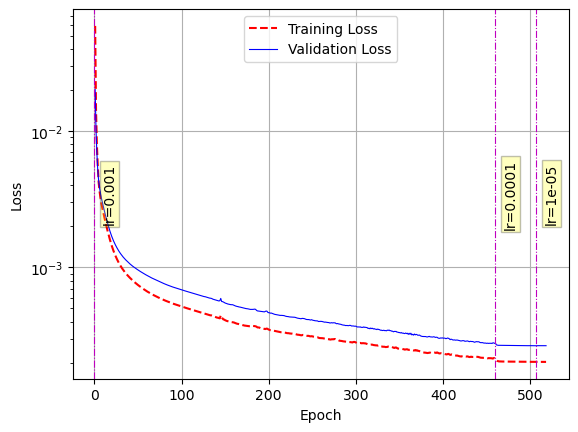

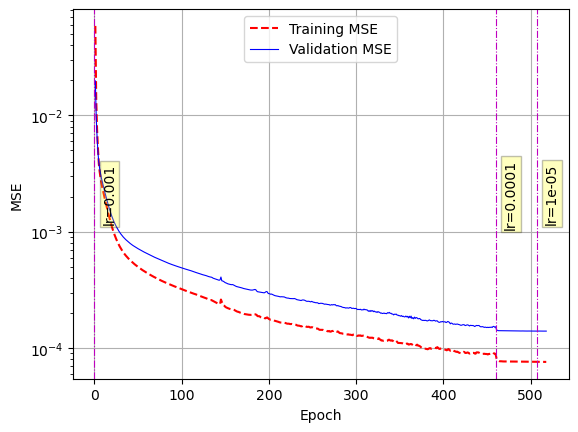

<Figure size 640x480 with 0 Axes>

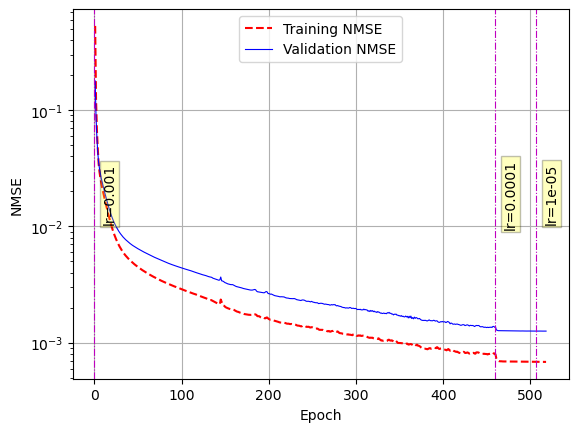

<Figure size 640x480 with 0 Axes>

In [37]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


data_idx : 52


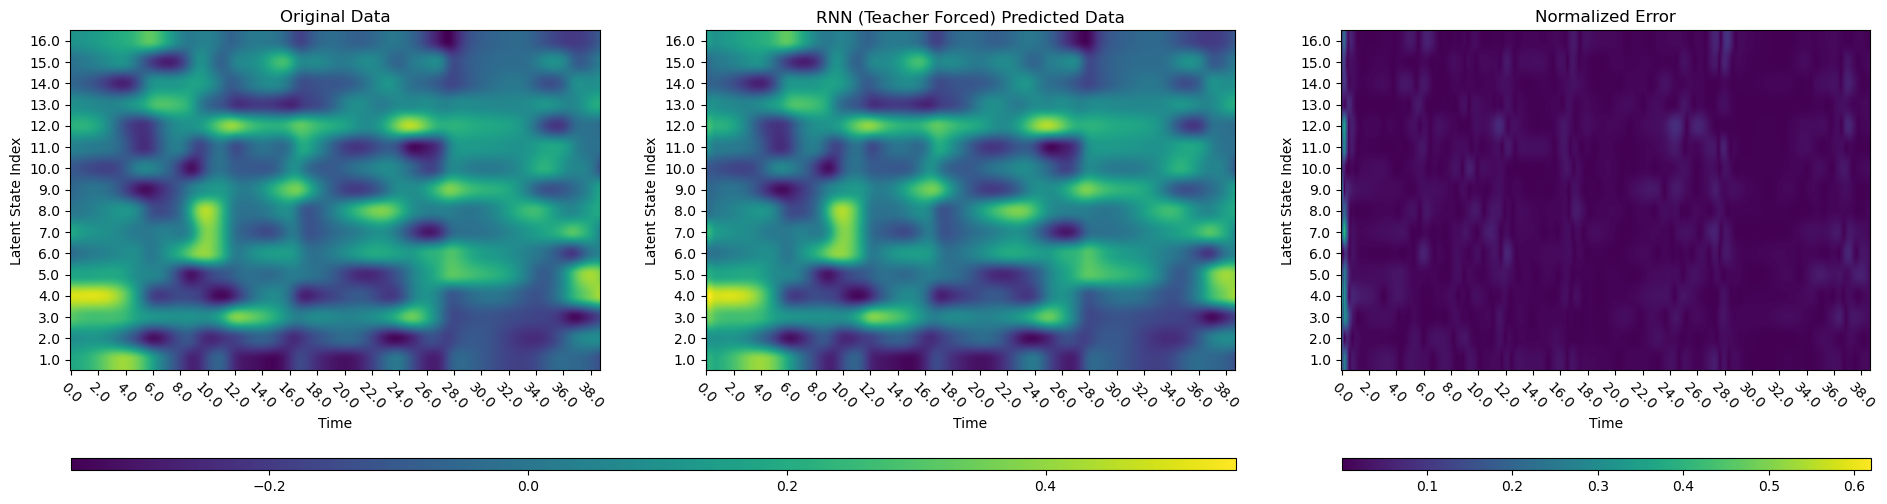

In [38]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [39]:
prediction.shape, data_out.shape, rnn_net.stateful

((64, 387, 16), (387, 16), True)

In [40]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    shape = new_data.shape
    print(shape)
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] = data[:, i]
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] = data[:, :, i]
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 26


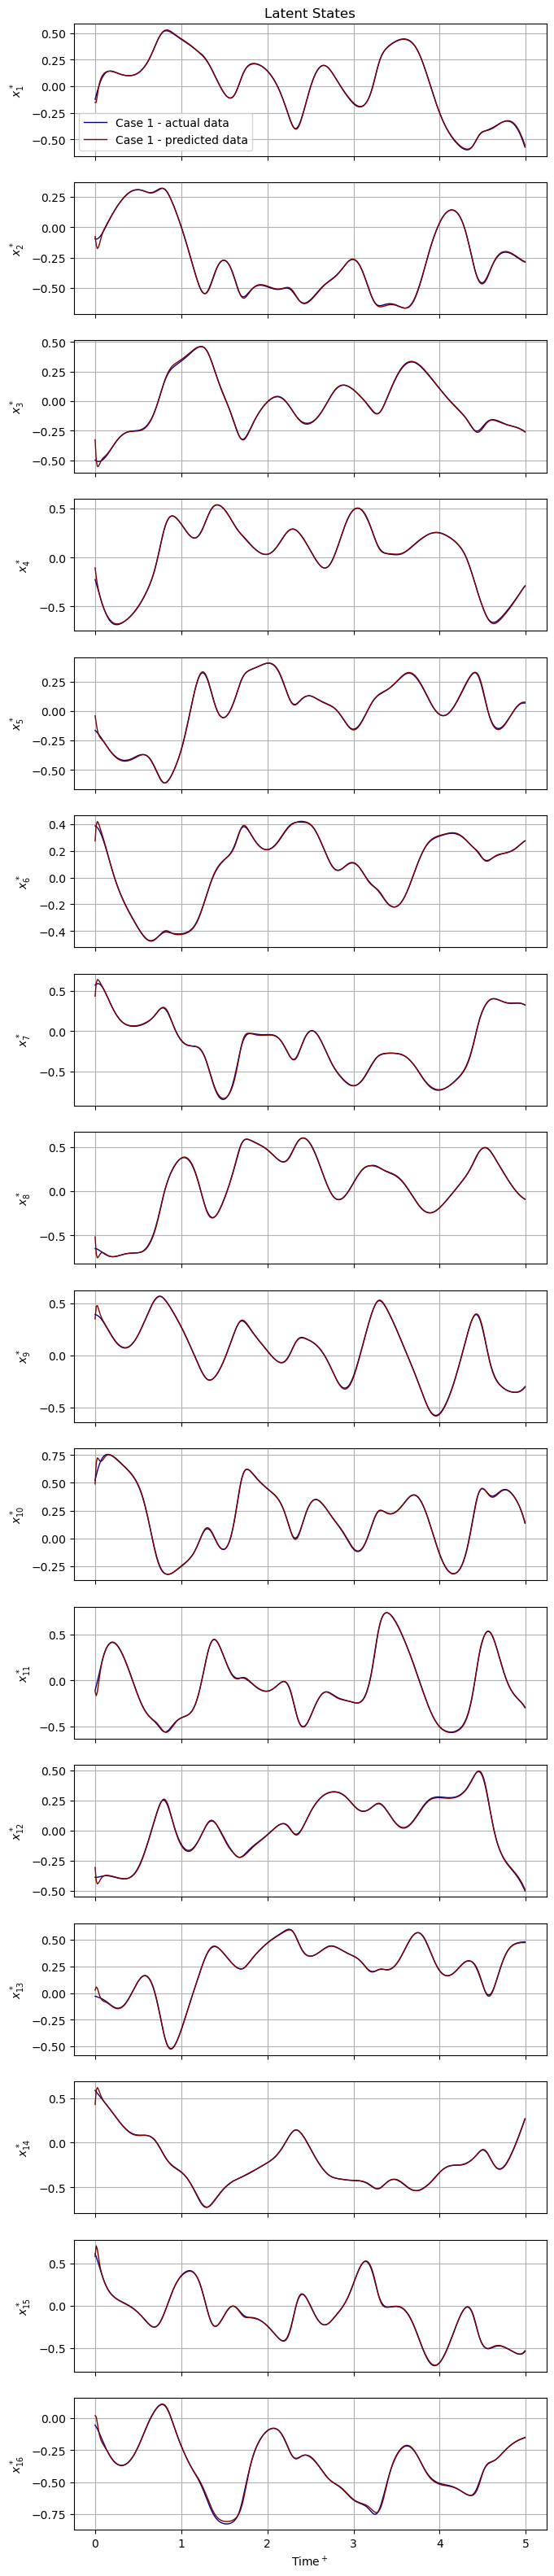


4.991497332033017


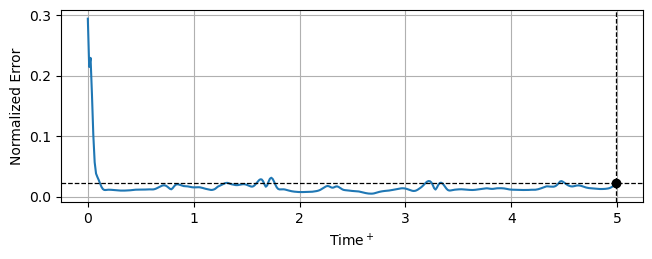

In [41]:
if rnn_net.stateful == True:
    for rnn_layer in rnn_net.rnn_list:
        rnn_layer.reset_states()


data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

In [42]:
normalization_arr

array([[-0.01334152, -0.00261581,  0.02099581,  0.03006471,  0.0282602 ,
         0.0071317 ,  0.01005646,  0.07305361,  0.03375387,  0.02128131,
        -0.01137792, -0.0153523 ,  0.02832958,  0.00729525,  0.06112615,
         0.03638883],
       [ 0.57221735,  0.5165402 ,  0.56873006,  0.5798129 ,  0.5267395 ,
         0.5602617 ,  0.5400706 ,  0.5276647 ,  0.55953586,  0.4929259 ,
         0.45475405,  0.5388398 ,  0.49729973,  0.5216943 ,  0.44654998,
         0.49534416]], dtype=float32)

# Autoregressive Mode

In [43]:
# s_in = testing_data_rnn_input.shape
# testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# # testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

# s_out = testing_data_rnn_output.shape
# testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# # testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [44]:
temp1 = np.empty_like(testing_data_rnn_input)
temp2 = np.empty_like(testing_data_rnn_output)

begin_idx = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_test = num_test_arr[i]

    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        temp1[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]
        temp2[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]

    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

In [45]:
testing_data_rnn_input_og = testing_data_rnn_input
testing_data_rnn_output_og = testing_data_rnn_output

testing_data_rnn_input = temp1
testing_data_rnn_output = temp2

In [46]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [47]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 10*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 2454
data_.shape : (1, 850, 16)


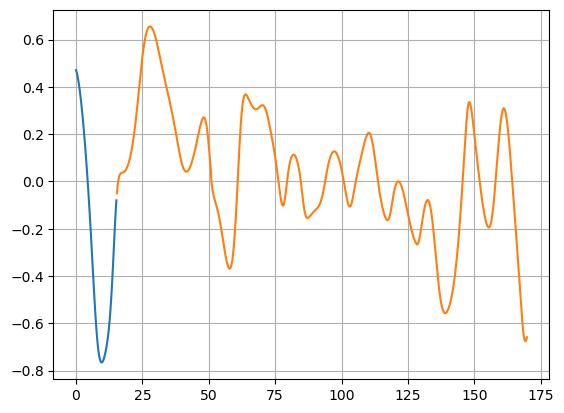

In [48]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [49]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    if layer.stateful == True:
        layer.reset_states()

    if data_.shape[0] != batch_size:
        data_ = np.tile(data_, (batch_size, 1, 1))
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :]))

prediction_lst.append(input_preds[:, -2:-1, :])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))
    prediction_lst.append(output[:, 0:1, :])

In [50]:
prediction_lst = np.stack(prediction_lst)
prediction_lst = np.squeeze(prediction_lst)
if rnn_net.stateful == True:
    prediction_lst = np.transpose(prediction_lst, [1, 0, 2])
# print(np.squeeze(prediction_lst).shape)
# print(np.transpose(prediction_lst, [1, 0, 2]).shape)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (64, 77, 16)
prediction_lst.shape : (64, 773, 16)


In [51]:
data_ = data_[0:1]
if rnn_net.stateful == True:
    prediction_lst = prediction_lst[0]
input_preds = input_preds[0]

0.4525969083449627


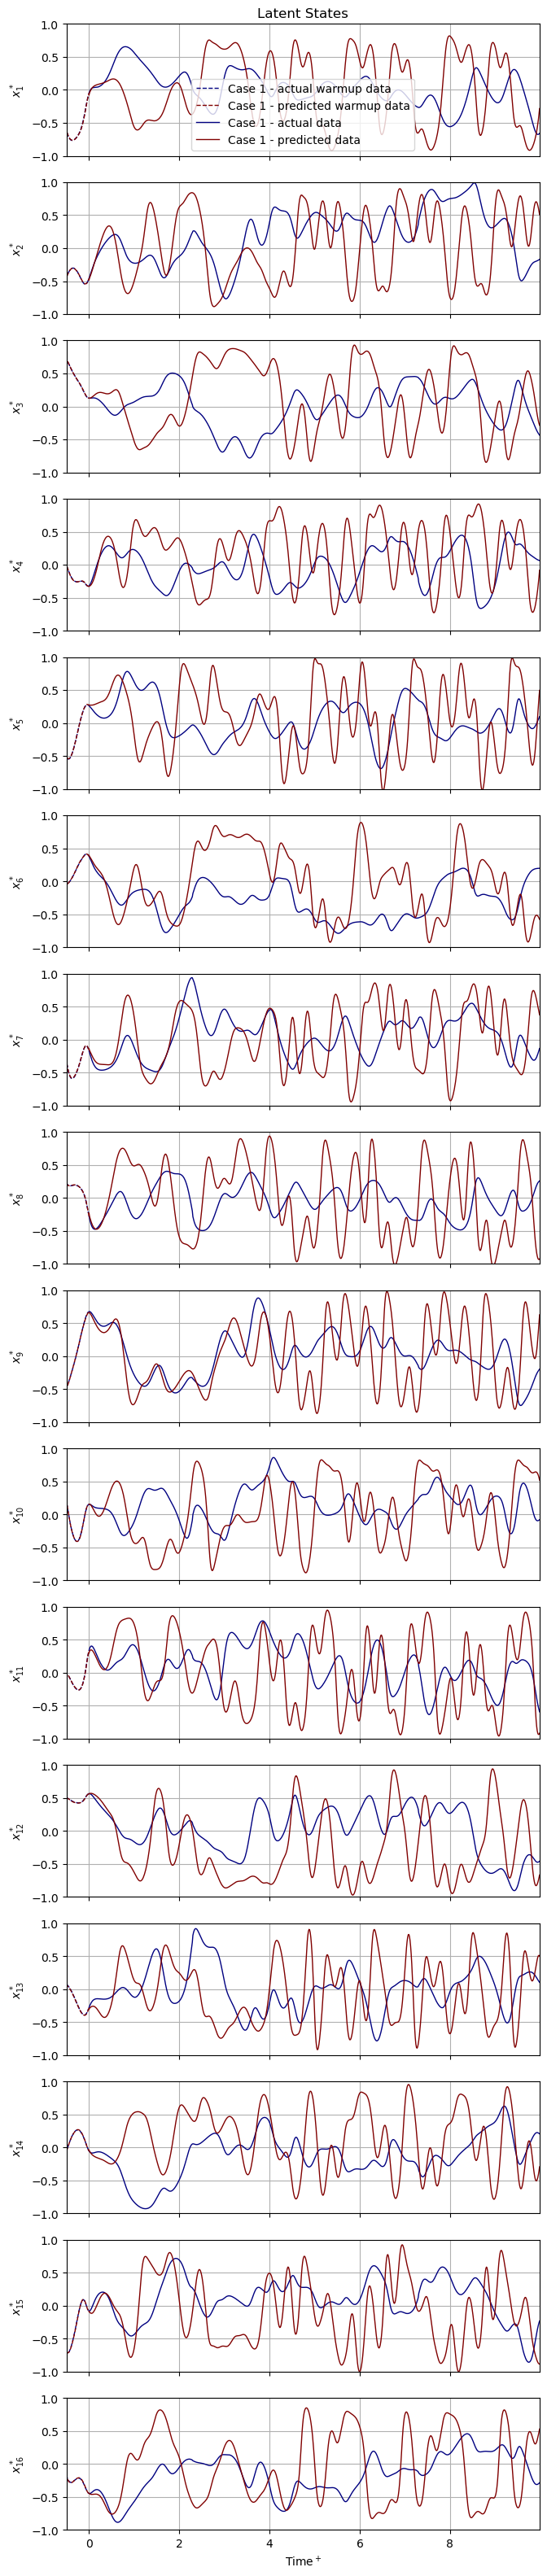

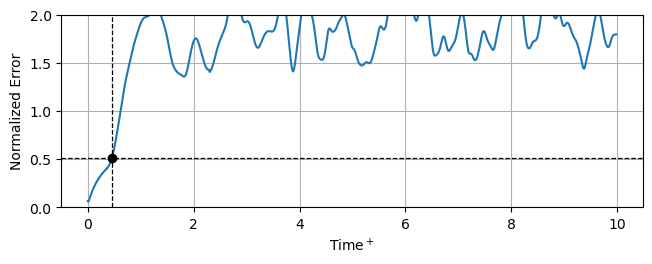

In [52]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [53]:
# sp = np.array([var.numpy() for var in rnn_net.scalar_multiplier_pre_list])
# print(sp)
# sum_ = np.sum(np.exp(sp))
# print(np.exp(sp)/sum_)

In [54]:
rnn_net.dense[-1].weights

[<tf.Variable 'rnn_gru/time_distributed_1/individual_weights:0' shape=(16,) dtype=float32, numpy=
 array([1.3630896, 1.498276 , 1.5187726, 1.3812348, 1.839515 , 1.4328601,
        1.4332173, 1.5444638, 1.6881909, 1.5358708, 1.3665315, 1.4479175,
        1.6744558, 1.5064002, 1.7539822, 1.0632821], dtype=float32)>]

In [55]:
if 'use_trainable_weights_with_reslayers' in rnn_net.__dict__.keys():
    if use_trainable_weights_with_reslayers == True:
        for i in range(rnn_net.num_skip_connections):
            print('reslayer_factor_{} : {}'.format(i, rnn_net.reslayer_factor[i]))